<a href="https://colab.research.google.com/github/taasinsaquib/ALL-Augmentations/blob/main/TransferLearning_and_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Move Files Around
* DON'T run this section

## Fixing a Mistake where I copied to the wrong place

In [ ]:
!find C-NMC_Leukemia/training_data/val/hem -maxdepth 1 -mindepth 1 -type f -ls -exec grep 'Dec' {} \; | wc -l

1514


In [ ]:
!find C-NMC_Leukemia/training_data/val/hem -maxdepth 1 -mindepth 1 -type f -ls -exec grep 'Aug' {} \; | wc -l

1512


In [ ]:
!ls -l C-NMC_Leukemia/training_data/aug/all | wc -l

1


In [ ]:
from pathlib import Path
import time

paths = sorted(Path(val_dst).iterdir(), key=os.path.getmtime)
count = 0
for p in paths:
  if "Aug" in time.ctime(os.path.getmtime(p)):
    count+=1
  else:
    os.remove(p)
  
print(count)
# print(len(paths))
# print(paths)

680


## Consolidate Training Folds

In [ ]:
import os
import shutil
from tqdm import tqdm

In [ ]:
def moveFiles(src, dest, filenames):
  for file_name in filenames:
    shutil.move(os.path.join(src, file_name), dest)

In [ ]:
path='/content/drive/My Drive/CS M226/C-NMC_Leukemia/training_data/'
fold0 = path+'fold_0/'
fold1 = path+'fold_1/'
fold2 = path+'fold_2/'

In [ ]:
dest_hem = fold0 + 'hem/'
src_hem  = fold1 + 'hem/'

In [ ]:
file_names = os.listdir(dest_hem)
print(len(file_names))

2709


In [ ]:
print(len(os.listdir(dest_hem)))
# moveFiles(src_hem, dest_hem, file_names)
print(len(os.listdir(dest_hem)))

2709
2709


In [ ]:
dest_all = fold0 + 'all/'
src_all  = fold2 + 'all/'

In [ ]:
file_names = os.listdir(dest_all)
print(len(file_names))

5822


In [ ]:
print(len(os.listdir(dest_all)))
# moveFiles(src_all, dest_all, file_names)
print(len(os.listdir(dest_all)))

5822
5822


## Create New Validation Folder

In [ ]:
# f = os.listdir('/content/drive/My Drive/CS M226/C-NMC_Leukemia/training_data/train/all/')
# print(len(f))

# ALL 7272, 0.2 = 1450
# HEM 3389, 0.2 = 680

In [ ]:
all_files = os.listdir(dest_all)
hem_files = os.listdir(dest_hem)

all_indices = np.random.choice(all_files, 1450, replace=False)
hem_indices = np.random.choice(hem_files, 680, replace=False)

In [ ]:
val_src = dest_hem
val_dst = path + 'val/' + 'hem'

print(len(os.listdir(val_dst)))
# moveFiles(val_src, val_dst, hem_indices)
print(len(os.listdir(val_dst)))

1450
1450


## Create New Augmentation Folder

In [ ]:
# ALL 5717, 0.3=1715
# HEM 2709, 0.3=812

In [ ]:
def copyFiles(src, dest, filenames):
  for file_name in tqdm(filenames):
    shutil.copy(os.path.join(src, file_name), dest)

In [ ]:
all_files = os.listdir(dest_all)
hem_files = os.listdir(dest_hem)

5822
2709


In [ ]:
all_indices_aug = np.random.choice(all_files, 1715, replace=False)
hem_indices_aug = np.random.choice(hem_files, 812, replace=False)

In [ ]:
aug_src = dest_hem
aug_dest = path + 'aug/' + 'hem'

print(len(os.listdir(aug_src)))
# copyFiles(aug_src, aug_dest, hem_indices_aug)
print(len(os.listdir(aug_dest)))

2709
812


# Connect to Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/My\ Drive/CS\ M226

/content/drive/.shortcut-targets-by-id/1r7MQOXDGZY7wBy0tWFKzg9Q9qokYEg0J/CS M226


# Load Model

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers.experimental import preprocessing
#from cnnArchitectures.Xception import get_xception_model
from sklearn.model_selection import StratifiedKFold
import os
import datetime

%matplotlib inline
%reload_ext tensorboard

In [ ]:
# Set up dataset parameters
BATCH_SIZE = 16
IMAGE_SIZE = (256, 256)
SEED = 322
PREFETCH_BUFFER_SIZE = 400
SHUFFLE_BUFFER_SIZE = 1000
CACHE_DIR = "caches/ds_cache"
ds_params = dict(
    labels="inferred",
    label_mode="categorical",
    class_names=["all", "hem"],
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    seed=SEED
)

In [ ]:
def get_cnn_model_1(input_shape):

    kernel_initializer = 'lecun_uniform'
    bias_initializer = 'lecun_uniform'
    kernel_regularizer = None
    activation = "selu"

    model = tf.keras.Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=input_shape, 
                     data_format="channels_last", kernel_initializer=kernel_initializer, 
                     bias_initializer=bias_initializer, kernel_regularizer=kernel_regularizer
                    ))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), data_format="channels_last", kernel_initializer=kernel_initializer, 
                     bias_initializer=bias_initializer, kernel_regularizer=kernel_regularizer
                    ))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(3, 3)))

    model.add(Conv2D(128, (3, 3), data_format="channels_last", kernel_initializer=kernel_initializer, 
                     bias_initializer=bias_initializer, kernel_regularizer=kernel_regularizer
                    ))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(3, 3)))

    model.add(Conv2D(256, (3, 3), data_format="channels_last", kernel_initializer=kernel_initializer, 
                     bias_initializer=bias_initializer, kernel_regularizer=kernel_regularizer
                    ))
    model.add(Activation(activation))
    model.add(Dropout(0.6))

    # adding fully connected layers
    model.add(Flatten())
    model.add(Dense(512, kernel_initializer=kernel_initializer, bias_initializer=bias_initializer))
    model.add(Activation(activation))
    model.add(Dropout(0.8))
    model.add(Dense(256, kernel_initializer=kernel_initializer, bias_initializer=bias_initializer))
    model.add(Activation(activation))
    model.add(Dropout(0.8))
    model.add(Dense(128, kernel_initializer=kernel_initializer, bias_initializer=bias_initializer))
    model.add(Activation(activation))
    model.add(Dropout(0.7))
    model.add(Dense(64, kernel_initializer=kernel_initializer, bias_initializer=bias_initializer))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    return model

In [ ]:
model = get_cnn_model_1(IMAGE_SIZE + (3,))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 254, 254, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
activation_1 (Activation)    (None, 125, 125, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 41, 41, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 39, 39, 128)       7

In [ ]:
model.load_weights("w.h5")

In [ ]:
adam_opt = tf.keras.optimizers.Adam(learning_rate=0.0001, amsgrad=True)
metrics = ["accuracy", tf.keras.metrics.Precision(name="precision")]

In [ ]:
# compile our new model
model.compile(
    optimizer=adam_opt,
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=metrics
)

In [ ]:
model_default = model
print(model_default.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 254, 254, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
activation_1 (Activation)    (None, 125, 125, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 41, 41, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 39, 39, 128)       7

# Create Data Splits

In [ ]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    './C-NMC_Leukemia/training_data/fold_0',
    labels="inferred",
    class_names=["all", "hem"],
    label_mode="int",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE, 
)

Found 8531 files belonging to 2 classes.


In [ ]:
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    './C-NMC_Leukemia/training_data/val',
    labels="inferred",
    class_names=["all", "hem"],
    label_mode="int",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE, 
    # seed=100,
    # validation_split=0.2,
    # subset='validation'
)

Found 2130 files belonging to 2 classes.


In [ ]:
test_df = pd.read_csv('./C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data_labels.csv')

In [ ]:
test_labels = test_df.labels.values
print(test_labels)

[1 1 1 ... 0 1 1]


In [ ]:
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    './C-NMC_Leukemia/validation_data/',
    labels=test_labels.tolist(),
    label_mode="int",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE, 
)

Found 1867 files belonging to 1 classes.


# Transfer Learning

In [ ]:
# Don't run this
for l in model_default.layers[:-5]:
  l.trainable = False

In [ ]:
# Don't run this
for l in model_default.layers:
  print(l.name, l.trainable)

In [ ]:
model_checkpoint_callback1 = tf.keras.callbacks.ModelCheckpoint(
    filepath="./prec_checkpoints/",
    save_weights_only=True,
    monitor='val_precision',
    mode='max',
    save_best_only=True)

model_checkpoint_callback2 = tf.keras.callbacks.ModelCheckpoint(
    filepath="./",
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
# One epoch takes like 10-15 minutes, so maybe 3 is the max we have time for
model_default_history = model_default.fit(train_data, epochs=5, callbacks=[model_checkpoint_callback1], validation_data=val_data)

# model_default.fit(train_0, epochs=20, callbacks=[model_checkpoint_callback1], validation_data=val_0)

Epoch 1/5
534/534 [==============================] - 2184s 4s/step - loss: 0.4825 - accuracy: 0.8164 - precision: 0.7789 - val_loss: 0.3605 - val_accuracy: 0.8484 - val_precision: 0.9685
Epoch 2/5
534/534 [==============================] - 179s 335ms/step - loss: 0.3900 - accuracy: 0.8468 - precision: 0.8338 - val_loss: 0.2692 - val_accuracy: 0.8958 - val_precision: 0.8990
Epoch 3/5
534/534 [==============================] - 178s 333ms/step - loss: 0.3823 - accuracy: 0.8524 - precision: 0.8472 - val_loss: 0.3039 - val_accuracy: 0.8878 - val_precision: 0.9002
Epoch 4/5
534/534 [==============================] - 179s 335ms/step - loss: 0.3357 - accuracy: 0.8732 - precision: 0.8727 - val_loss: 0.3790 - val_accuracy: 0.8230 - val_precision: 0.9967
Epoch 5/5
534/534 [==============================] - 180s 338ms/step - loss: 0.3083 - accuracy: 0.8865 - precision: 0.8867 - val_loss: 0.3602 - val_accuracy: 0.8221 - val_precision: 1.0000


In [ ]:
# save the model and history (just in case we need it later)
import pickle

# model_retrain_noise.model.save_weights('./retrain_imbalance/noise')
model_default_history.model.save('./retrain_inception_resnet/model_default')

model_default_history.model.evaluate(test_data, batch_size=128)

INFO:tensorflow:Assets written to: ./retrain_inception_resnet/model_default/assets
117/117 [==============================] - 493s 4s/step - loss: 1.6811 - accuracy: 0.3626 - precision: 0.7302


[1.6810966730117798, 0.36261382699012756, 0.7301587462425232]

In [ ]:
# Save history
with open('./retrain_inception_resnet/model_default_history', 'wb') as file_pi:
  pickle.dump(model_default_history.history, file_pi) 

In [ ]:
def transfer_learn(model, epochs, train_data, val_data):

  # make last few layers the only trainable ones
  for l in model.layers[:-5]:
    l.trainable = False

  return model.fit(train_data, epochs=epochs, callbacks=[model_checkpoint_callback1], validation_data=val_data)

In [ ]:
def retrain(model, epochs, train_data, val_data):
  for l in model.layers:
    l.set_trainable = True
  
  return model.fit(train_data, epochs=epochs, callbacks=[model_checkpoint_callback1], validation_data=val_data)

# Create Augmented Datasets

In [ ]:
import cv2
import pandas as pd

## Code to Combine Generators (didn't work)

In [ ]:
def getDataframe(path):
  #return df with filenames and labels, chose 30% of data randomly to put in this df

  all = path+'all/'
  files = os.listdir(all)
  # augment 30% of images
  nFilesToAugment = int(len(files) * 0.3)
  all_filesToAugment = np.random.choice(files, nFilesToAugment, replace=False)
  all_filesToAugment = [all+f for f in all_filesToAugment]

  all_labels = ['1'] * nFilesToAugment

  hem = path+'hem/'
  files = os.listdir(hem)
  # augment 30% of images
  nFilesToAugment = int(len(files) * 0.3)
  hem_filesToAugment = np.random.choice(files, nFilesToAugment, replace=False)
  hem_filesToAugment = [hem+f for f in hem_filesToAugment]

  hem_labels = ['0'] * nFilesToAugment

  # create df
  filenames = np.concatenate((all_filesToAugment, hem_filesToAugment), axis=0)
  labels = all_labels + hem_labels

  d = {"files": filenames, "labels": labels}
  df = pd.DataFrame(data=d)
  
  # shuffle
  df = df.sample(frac=1) 

  return df

In [ ]:
# https://stackoverflow.com/questions/46313525/how-do-i-combine-two-keras-generator-functions
def combine_generator(gen1, gen2):
    while True:
        # yield(next(gen1), next(gen2))
        X1i = gen1.next()
        X2i = gen2.next()

        yield X1i[0], X2i[0]

In [ ]:
seed = 528

## Flipped

In [ ]:
# dummy preprocessing for flip
def preprocessing_flip(img):
  # plt.imshow(img)
  return img

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range = 0.2
    # preprocessing_function=preprocessing_flip
)

In [ ]:
train_data_flipped = datagen.flow_from_directory(
    './C-NMC_Leukemia/training_data/aug',
    class_mode='binary',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

Found 2527 images belonging to 2 classes.


In [ ]:
first_item = train_data_flipped.__getitem__(0)
print(first_item.count)

<built-in method count of tuple object at 0x7f88076dd608>


## Blur (train_data_blur)

In [ ]:
np.random.seed(1234)

In [ ]:
def preprocessing_blur(img):
  number_list = np.random.choice(3, 1, p = [0.33, 0.37, 0.30])
  if number_list[0] == 0:
    newImg = cv2.GaussianBlur(img, (21, 21),0)
    return newImg
  return img

In [ ]:
datagen_blur = tf.keras.preprocessing.image.ImageDataGenerator(
    # rescale=1./255, 
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range = 0.2,
    preprocessing_function=preprocessing_blur,
    featurewise_center=True,
    featurewise_std_normalization=True
)

In [ ]:
# df_blur = getDataframe('./C-NMC_Leukemia/training_data/train/')

In [ ]:
train_data_blur = datagen_blur.flow_from_directory (
    './C-NMC_Leukemia/training_data/fold_0',
    class_mode='binary',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='rgb'
    # seed=seed
)

Found 8531 images belonging to 2 classes.


## Noise (train_data_noise)

In [ ]:
from skimage.util import random_noise

In [ ]:
def preprocessing_noise(img):
  number_list = np.random.choice(3, 1, p = [0.33, 0.37, 0.30])
  if number_list[0] == 0:
    newImg = random_noise(img, mode='gaussian', mean=0, var=0.1, clip=False)
    return newImg
  return img

In [ ]:
datagen_noise = tf.keras.preprocessing.image.ImageDataGenerator(
    # rescale=1./255, 
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range = 0.2,
    preprocessing_function=preprocessing_noise,
)

In [ ]:
train_data_noise = datagen_noise.flow_from_directory (
    './C-NMC_Leukemia/training_data/fold_0',
    class_mode='binary',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE, 
)

Found 8531 images belonging to 2 classes.


## Greyscale (train_data_grey)

In [ ]:
def preprocessing_grey(img):
  return random_noise(img, mode='gaussian', mean=0, var=0.01, clip=True)

In [ ]:
datagen_grey = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range = 0.2,
    preprocessing_function=preprocessing_grey,
)

In [ ]:
# df_grey = getDataframe('./C-NMC_Leukemia/training_data/train/')

In [ ]:
train_data_grey = datagen_noise.flow_from_directory (
    './C-NMC_Leukemia/training_data/aug',
    class_mode='binary',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE, 
)

Found 2527 images belonging to 2 classes.


In [ ]:
# train_data_grey = zip(train_data, train_data_grey)

# Evaluate Default Model

In [ ]:
results = model_default.evaluate(test_images, batch_size=128)
print("test loss, test acc:", results)

117/117 [==============================] - 477s 4s/step - loss: 1.5249 - accuracy: 0.3739 - precision: 0.6786
test loss, test acc: [1.5248767137527466, 0.37386181950569153, 0.6785714030265808]


# Full Workflow

## Retrain Flipped Transfer Learning Model

In [ ]:
# re-train flipped transfer learning model

model_flipped = transfer_learn(model_default, 5, train_data_flipped, val_data)
# model_flipped.model.save_weights("./w_flipped.hdf5")

Epoch 1/5
158/158 [==============================] - 1344s 9s/step - loss: 0.6446 - accuracy: 0.6791 - precision: 0.5015 - val_loss: 0.6322 - val_accuracy: 0.8178 - val_precision: 0.7500
Epoch 2/5
158/158 [==============================] - 57s 359ms/step - loss: 0.5552 - accuracy: 0.7372 - precision: 0.6462 - val_loss: 0.7729 - val_accuracy: 0.8056 - val_precision: 0.6962
Epoch 3/5
158/158 [==============================] - 48s 303ms/step - loss: 0.5470 - accuracy: 0.7511 - precision: 0.6770 - val_loss: 1.5111 - val_accuracy: 0.7714 - val_precision: 0.6059
Epoch 4/5
158/158 [==============================] - 48s 304ms/step - loss: 0.5090 - accuracy: 0.7677 - precision: 0.7135 - val_loss: 2.7006 - val_accuracy: 0.7352 - val_precision: 0.5561
Epoch 5/5
158/158 [==============================] - 47s 299ms/step - loss: 0.5007 - accuracy: 0.7780 - precision: 0.7278 - val_loss: 3.2969 - val_accuracy: 0.7042 - val_precision: 0.5222


In [ ]:
import pickle

In [ ]:
# model_retrain_noise.model.save_weights('./retrain_imbalance/noise')
model_flipped.model.save('./retrain_inception_resnet/flipped')

model_flipped.model.evaluate(test_data, batch_size=128)


In [ ]:
# Save history
with open('./retrain_inception_resnet/flipped_history', 'wb') as file_pi:
  pickle.dump(model_flipped.history, file_pi) 

In [ ]:
# evaluate results
# results_flipped = model_default.evaluate(test_images, batch_size=128)
# print("test loss, test acc:", results_flipped)

## Retrain Noise Transfer Learning Model
* @Marlin, just replicate the 3 cells below for each augmentation dataset I created
  * 3 epochs take me like an hour, but you can try more if you want
* If you get through those, try combining augmentations by looking at the code in section 'Created Augmented Datasets'

In [ ]:
# Noise
model_noise = transfer_learn(model_default, 5, train_data_flipped, val_data)

Epoch 1/5
158/158 [==============================] - 48s 302ms/step - loss: 0.4636 - accuracy: 0.7998 - precision: 0.7567 - val_loss: 11.2080 - val_accuracy: 0.4901 - val_precision: 0.3803
Epoch 2/5
158/158 [==============================] - 48s 303ms/step - loss: 0.4360 - accuracy: 0.8077 - precision: 0.7717 - val_loss: 6.2677 - val_accuracy: 0.5169 - val_precision: 0.3927
Epoch 3/5
158/158 [==============================] - 48s 302ms/step - loss: 0.4282 - accuracy: 0.8223 - precision: 0.7923 - val_loss: 7.2848 - val_accuracy: 0.5089 - val_precision: 0.3895
Epoch 4/5
158/158 [==============================] - 48s 304ms/step - loss: 0.4149 - accuracy: 0.8294 - precision: 0.8000 - val_loss: 12.2140 - val_accuracy: 0.4202 - val_precision: 0.3520
Epoch 5/5
158/158 [==============================] - 48s 303ms/step - loss: 0.3916 - accuracy: 0.8350 - precision: 0.8006 - val_loss: 8.3884 - val_accuracy: 0.4648 - val_precision: 0.3705


In [ ]:
# model_noise.model.save_weights("./w_noise.hdf5")

In [ ]:
# model_retrain_noise.model.save_weights('./retrain_imbalance/noise')
model_noise.model.save('./retrain_inception_resnet/noise')

model_noise.model.evaluate(test_data, batch_size=128)

INFO:tensorflow:Assets written to: ./retrain_inception_resnet/noise/assets
117/117 [==============================] - 9s 76ms/step - loss: 1.3184 - accuracy: 0.3685 - precision: 0.6099


[1.3183867931365967, 0.3685056269168854, 0.6098901033401489]

In [ ]:
# Save history
with open('./retrain_inception_resnet/noise_history', 'wb') as file_pi:
  pickle.dump(model_noise.history, file_pi) 

In [ ]:
# results_noise = model_noise.model.evaluate(test_data, batch_size=128)
# print("test loss, test acc:", results_noise)

117/117 [==============================] - 29s 251ms/step - loss: 21.8192 - accuracy: 0.6508 - precision: 0.6528
test loss, test acc: [21.819196701049805, 0.6507766246795654, 0.652830183506012]


## Retrain Blur Transfer Learning Model

In [ ]:
# Noise
model_blur = transfer_learn(model_default, 5, train_data_blur, val_data)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/5
534/534 [==============================] - 2289s 4s/step - loss: 0.7245 - accuracy: 0.7209 - precision: 0.5989 - val_loss: 0.4399 - val_accuracy: 0.7920 - val_precision: 0.9958
Epoch 2/5
534/534 [==============================] - 196s 367ms/step - loss: 0.4956 - accuracy: 0.7861 - precision: 0.7509 - val_loss: 0.3538 - val_accuracy: 0.8498 - val_precision: 0.9545
Epoch 3/5
534/534 [==============================] - 197s 369ms/step - loss: 0.4655 - accuracy: 0.8020 - precision: 0.7881 - val_loss: 0.4038 - val_accuracy: 0.8122 - val_precision: 0.9965
Epoch 4/5
534/534 [==============================] - 193s 362ms/step - loss: 0.4458 - accuracy: 0.8157 - precision: 0.8068 - val_loss: 0.3361 - val_accuracy: 0.8441 - val_precision: 0.9807
Epoch 5/5
534/534 [==============================] - 192s 360ms/step - loss: 0.4332 - accuracy: 0.8212 - precision: 0.8071 - val_loss: 0.2963 - val_accuracy: 0.8812 - val_precision: 0.9211


In [ ]:
# model_blur.model.save_weights("./w_noise.hdf5")

In [ ]:
# model_retrain_noise.model.save_weights('./retrain_imbalance/noise')
model_blur.model.save('./retrain_inception_resnet/blur')

model_blur.model.evaluate(test_data, batch_size=128)

INFO:tensorflow:Assets written to: ./retrain_inception_resnet/blur/assets
117/117 [==============================] - 9s 73ms/step - loss: 1.3184 - accuracy: 0.3685 - precision: 0.6099


[1.3183866739273071, 0.3685056269168854, 0.6098901033401489]

In [ ]:
# Save history
with open('./retrain_inception_resnet/blur_history', 'wb') as file_pi:
  pickle.dump(model_blur.history, file_pi) 

In [ ]:
# results_noise = model_noise.model.evaluate(test_data, batch_size=128)
# print("test loss, test acc:", results_noise)

# Model replication for ther datasets

## Blur

In [ ]:
# Blur
model_blur = transfer_learn(model_default, 5, test, val_data)

In [ ]:
print(model_blur)
print(model_blur.model.get_weights)

<bound method Model.get_weights of <tensorflow.python.keras.engine.sequential.Sequential object at 0x7fd4f5cbe978>>


In [ ]:
# model_blur.save_weights("./w_blur.hdf5")

model_blur.model.save_weights('./w_blur.hdf5')

In [ ]:
# replacing test_images for test_data

results_blur = model_blur.model.evaluate(test_data, batch_size=128)
print("test loss, test acc:", results_blur)

117/117 [==============================] - 485s 4s/step - loss: 3.7525 - accuracy: 0.5983 - precision: 0.6548
test loss, test acc: [3.752495527267456, 0.5982860326766968, 0.6547854542732239]


## Grayscale

In [ ]:
# Grayscale
model_grayscale = transfer_learn(model_default, 3, train_data_flipped, val_data)

Epoch 1/3
427/427 [==============================] - 163s 382ms/step - loss: 0.4542 - accuracy: 0.8072 - precision: 0.6468 - val_loss: 7.4846 - val_accuracy: 0.6906 - val_precision: 0.6934
Epoch 2/3
427/427 [==============================] - 161s 376ms/step - loss: 0.4300 - accuracy: 0.8244 - precision: 0.6923 - val_loss: 11.0075 - val_accuracy: 0.6826 - val_precision: 0.6825
Epoch 3/3
427/427 [==============================] - 160s 376ms/step - loss: 0.4058 - accuracy: 0.8332 - precision: 0.7258 - val_loss: 19.0789 - val_accuracy: 0.6821 - val_precision: 0.6823


In [ ]:
model_grayscale.model.save_weights("./w_grayscale.hdf5")

In [ ]:
results_grayscale = model_grayscale.model.evaluate(test_data, batch_size=128)
print("test loss, test acc:", results_grayscale)

117/117 [==============================] - 29s 251ms/step - loss: 24.5485 - accuracy: 0.6513 - precision: 0.6527
test loss, test acc: [24.548465728759766, 0.6513122916221619, 0.6526881456375122]


In [ ]:
train_data_grey_zip = zip(train_data, train_data_grey)

In [ ]:
# Grayscale
model_grayscale_new = transfer_learn(model_default, 3, train_data_grey_zip, val_data)

# Implementation

In [ ]:
# transfer learning on the noise dataset
model_train_noise = model_default

model_train_noise = transfer_learn(model_train_noise, 3, train_data_noise, val_data)


Epoch 1/3
158/158 [==============================] - 107s 677ms/step - loss: 0.5563 - accuracy: 0.7471 - precision: 0.6784 - val_loss: 0.4034 - val_accuracy: 0.8225 - val_precision: 0.9809
Epoch 2/3
158/158 [==============================] - 72s 454ms/step - loss: 0.5123 - accuracy: 0.7824 - precision: 0.7391 - val_loss: 0.4313 - val_accuracy: 0.7962 - val_precision: 0.9920
Epoch 3/3
158/158 [==============================] - 72s 455ms/step - loss: 0.4899 - accuracy: 0.7915 - precision: 0.7577 - val_loss: 0.5744 - val_accuracy: 0.7446 - val_precision: 1.0000


In [ ]:
# evaluate the noise model
model_noise_eval = model_train_noise.model.evaluate(test_data, batch_size=128)

117/117 [==============================] - 29s 248ms/step - loss: 2.0918 - accuracy: 0.3519 - precision: 0.7647


Retrain Noise Model

In [ ]:
# model_retrain_noise = 

# model = get_cnn_model_1(IMAGE_SIZE + (3,))

In [ ]:
first_item = train_data_noise.__getitem__(0)
print(first_item.count)

In [ ]:
# leave this last
# transfer learning on the flipped dataset

model_train_flipped = model_default

model_train_flipped = transfer_learn(model_train_flipped, 1, train_data_flipped, val_data)

158/158 [==============================] - 1365s 9s/step - loss: 0.6499 - accuracy: 0.6664 - precision: 0.4448 - val_loss: 0.8422 - val_accuracy: 0.8047 - val_precision: 0.7050


In [ ]:
# evaluate the flipped model

model_flipped_eval = model_train_flipped.model.evaluate(test_data, batch_size=128)

117/117 [==============================] - 438s 4s/step - loss: 2.1606 - accuracy: 0.3996 - precision: 0.6303


In [ ]:
# transfer learning on the blur dataset
model_train_blur = model_default

model_train_blur = transfer_learn(model_train_blur, 3, train_data_blur, val_data)

In [ ]:
# evaluate the blur model
model_blur_eval = model_train_blur.model.evaluate(test_data, batch_size=128)

117/117 [==============================] - 29s 248ms/step - loss: 1.4774 - accuracy: 0.3621 - precision: 0.6707


Retrain Model Blur

In [ ]:
# TODO instead of train_data_blur try to concatenate both training and 

model_retrain_blur = model

model_retrain_blur = retrain(model_retrain_blur, 5, train_data_blur, val_data)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/5
534/534 [==============================] - 2427s 5s/step - loss: 0.4299 - accuracy: 0.8237 - precision: 0.8186 - val_loss: 0.3269 - val_accuracy: 0.8789 - val_precision: 0.9607
Epoch 2/5
534/534 [==============================] - 208s 390ms/step - loss: 0.4037 - accuracy: 0.8311 - precision: 0.8401 - val_loss: 0.3423 - val_accuracy: 0.8493 - val_precision: 0.9972
Epoch 3/5
534/534 [==============================] - 203s 380ms/step - loss: 0.3797 - accuracy: 0.8475 - precision: 0.8574 - val_loss: 0.2819 - val_accuracy: 0.8822 - val_precision: 0.9694
Epoch 4/5
534/534 [==============================] - 203s 379ms/step - loss: 0.3835 - accuracy: 0.8467 - precision: 0.8533 - val_loss: 0.5372 - val_accuracy: 0.7653 - val_precision: 1.0000
Epoch 5/5
534/534 [==============================] - 201s 376ms/step - loss: 0.3915 - accuracy: 0.8421 - precision: 0.8464 - val_loss: 0.3792 - val_accuracy: 0.8038 - val_precision: 1.0000


In [ ]:
# save the model weights
model_retrain_blur.model.save_weights('./retrain_blur.hdf5')

In [ ]:
# evaluate the retrained model
model_retrain_blur.model.evaluate(test_data, batch_size=128)

117/117 [==============================] - 29s 252ms/step - loss: 1.5392 - accuracy: 0.3498 - precision: 0.6923


[1.5391560792922974, 0.34975898265838623, 0.692307710647583]

Apply SGD optimization to the blur data augmentation

In [ ]:
# try again, but comparing SGD versus Adam
# assuming same learning rate as the Adam implementation

model_retrain_blur_sgd = model

# new optimizations
sgd_opt = tf.keras.optimizers.SGD(learning_rate=0.0001)
metrics = ["accuracy", tf.keras.metrics.Precision(name="precision")]

# compile our new model
model_retrain_blur_sgd.compile(
    optimizer=sgd_opt,
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=metrics
)

In [ ]:
# retrain the model

model_retrain_blur_sgd = retrain(model_retrain_blur_sgd, 10, train_data_blur, val_data)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/10
534/534 [==============================] - 190s 355ms/step - loss: 0.3786 - accuracy: 0.8371 - precision: 0.8985 - val_loss: 0.3642 - val_accuracy: 0.8324 - val_precision: 0.9969
Epoch 2/10
534/534 [==============================] - 193s 361ms/step - loss: 0.3849 - accuracy: 0.8364 - precision: 0.9005 - val_loss: 0.3595 - val_accuracy: 0.8347 - val_precision: 0.9970
Epoch 3/10
534/534 [==============================] - 193s 361ms/step - loss: 0.3749 - accuracy: 0.8425 - precision: 0.9070 - val_loss: 0.3535 - val_accuracy: 0.8362 - val_precision: 0.9970
Epoch 4/10
534/534 [==============================] - 194s 364ms/step - loss: 0.3721 - accuracy: 0.8422 - precision: 0.9006 - val_loss: 0.3516 - val_accuracy: 0.8371 - val_precision: 0.9970
Epoch 5/10
534/534 [==============================] - 195s 366ms/step - loss: 0.3749 - accuracy: 0.8405 - precision: 0.8988 - val_loss: 0.3568 - val_accuracy: 0.8362 - val_precision: 0.9970
Epoch 6/10
534/534 [==============================

In [ ]:
# save the model weights
model_retrain_blur_sgd.model.save_weights('./retrain_blur_sgd.hdf5')

In [ ]:
# evaluate the retrained model
model_retrain_blur_sgd.model.evaluate(test_data, batch_size=128)

117/117 [==============================] - 30s 253ms/step - loss: 1.9457 - accuracy: 0.3557 - precision: 0.6667


[1.945739507675171, 0.35565078258514404, 0.6666666865348816]

Retrain the noise model

In [ ]:
# TODO instead of train_data_blur try to concatenate both training and 

model_retrain_noise = model

model_retrain_noise = retrain(model_retrain_noise, 5, train_data_noise, val_data)

In [ ]:
# save the model weights
model_retrain_noise.model.save_weights('./retrain_noise.hdf5')

In [ ]:
# evaluate the retrained model
model_retrain_noise.model.evaluate(test_data, batch_size=128)

In [ ]:
# transfer learning on the greyscale dataset
model_train_grey = model_default

model_train_grey = transfer_learn(model_train_grey, 1, train_data_grey, val_data)

In [ ]:
# evaluate the greyscale model
model_grey_eval = model_train_grey.model.evaluate(test_data, batch_size=128)

# Implement InceptionV3 and Resnet

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model

In [ ]:
# Creating model with pre trained imagenet weights

incep_v3 = InceptionV3(include_top=False, weights='imagenet', input_shape=(128,128,3))

for layers in incep_v3.layers:
    layers.trainable = False


x = Flatten()(incep_v3.output)

fcc_layer_1 = Dense(units = 1024, activation = 'relu')(x)
dropout_1   = Dropout(0.3)(fcc_layer_1)

fcc_layer_2 = Dense(units = 512, activation = 'relu')(dropout_1)
dropout_2   = Dropout(0.3)(fcc_layer_2)

final_layer = Dense(units = 1, activation = 'sigmoid')(dropout_2)

model_incepV3 = Model(inputs = incep_v3.input, outputs = final_layer)

model_incepV3.compile(optimizer = 'adam', 
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [ ]:
model_incepV3 = tf.keras.models.load_model('best_weights.hdf5')

In [ ]:
test_data_incep = tf.keras.preprocessing.image_dataset_from_directory(
    './C-NMC_Leukemia/validation_data/',
    labels=test_labels.tolist(),
    label_mode="int",
    image_size=(128, 128),
    batch_size=BATCH_SIZE, 
)

Found 1867 files belonging to 1 classes.


In [ ]:
model_incepV3.evaluate(test_data_incep, callbacks=[model_checkpoint_callback1], batch_size=128)

117/117 [==============================] - 8s 72ms/step - loss: 6.9853 - accuracy: 0.6529


[6.9853410720825195, 0.6529191136360168]

ResNet

In [ ]:
from tensorflow.keras.applications import ResNet50V2

In [ ]:
model_resnet = ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(128,128, 3),
    pooling=None,
    classes=1,
    classifier_activation="softmax",
)

94674944/94668760 [==============================] - 1s 0us/step


In [ ]:
for layers in model_resnet.layers:
  layers.trainable = False

x = Flatten()(model_resnet.output)

fcc_layer_1 = Dense(units = 1024, activation = 'relu')(x)
dropout_1   = Dropout(0.3)(fcc_layer_1)

fcc_layer_2 = Dense(units = 512, activation = 'relu')(dropout_1)
dropout_2   = Dropout(0.3)(fcc_layer_2)

final_layer = Dense(units = 1, activation = 'sigmoid')(dropout_2)

model_resnet = Model(inputs = model_resnet.input, outputs = final_layer)

model_resnet.compile(optimizer = 'adam', 
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [ ]:
model_resnet = tf.keras.models.load_model('best_weights_resnet.hdf5')

In [ ]:
test_data_resnet = tf.keras.preprocessing.image_dataset_from_directory(
    './C-NMC_Leukemia/validation_data/',
    labels=test_labels.tolist(),
    label_mode="int",
    image_size=(128, 128),
    batch_size=BATCH_SIZE, 
)

Found 1867 files belonging to 1 classes.


In [ ]:
model_resnet.evaluate(test_data_resnet, callbacks=[model_checkpoint_callback1], batch_size=128)

117/117 [==============================] - 8s 69ms/step - loss: 2.9765 - accuracy: 0.6535


[2.9765355587005615, 0.6534547209739685]

# Graphical Representations for Information


## InceptionV3 Data

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model

In [ ]:
# Creating model with pre trained imagenet weights

incep_v3 = InceptionV3(include_top=False, weights='imagenet', input_shape=(128,128,3))

for layers in incep_v3.layers:
    layers.trainable = False


x = Flatten()(incep_v3.output)

fcc_layer_1 = Dense(units = 1024, activation = 'relu')(x)
dropout_1   = Dropout(0.3)(fcc_layer_1)

fcc_layer_2 = Dense(units = 512, activation = 'relu')(dropout_1)
dropout_2   = Dropout(0.3)(fcc_layer_2)

final_layer = Dense(units = 1, activation = 'sigmoid')(dropout_2)

model_incepV3 = Model(inputs = incep_v3.input, outputs = final_layer)

model_incepV3.compile(optimizer = 'adam', 
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
# load existing model weights

model_incepV3 = tf.keras.models.load_model('best_weights.hdf5')

In [ ]:
# define (128, 128) image data for the training

test_data_128 = tf.keras.preprocessing.image_dataset_from_directory(
    './C-NMC_Leukemia/validation_data/',
    labels=test_labels.tolist(),
    label_mode="int",
    image_size=(128, 128),
    batch_size=BATCH_SIZE, 
)

Found 1867 files belonging to 1 classes.


In [ ]:
# evaluate the model
model_incepV3_eval = model_incepV3.evaluate(test_data_128, batch_size=128)

# obtain the model loss and accuracy

loss_incepv3 = model_incepV3_eval[0]
accuracy_incepv3 = model_incepV3_eval[1]

117/117 [==============================] - 8s 70ms/step - loss: 6.9853 - accuracy: 0.6529


In [ ]:
predict_incepV3 = model_incepV3.predict(test_data_128, batch_size=128)

For now, is assumes a Gaussian Distribution for Prediction Accuracy

Assumes values of Z:

1.64 (90%)

1.96 (95%)

2.33 (98%)

2.58 (99%)


In [ ]:
# Computes confidence interval without changing the network architecture
# assuming Gaussian distribution of prediction accuracy

# size of our test dataset
n = predict_incepV3.shape[0]

# assuming 95% confidence interval
Z = 1.96

conf_radius_incepV3 = Z * np.sqrt((accuracy_incepv3 * (1 - accuracy_incepv3)) / n)

conf_incepV3_lower = accuracy_incepv3 - conf_radius_incepV3
conf_incepV3_upper = accuracy_incepv3 + conf_radius_incepV3

In [ ]:
print('radius: ', conf_radius_incepV3)
print('lower bound: ', conf_incepV3_lower)
print('upper bound: ', conf_incepV3_upper)

radius:  0.021593793926591463
lower bound:  0.6313253197094254
upper bound:  0.6745129075626083


In [ ]:
# reshaping test_labels so it's same shape as predictions

test_labels_reshape = test_labels.reshape((test_labels.shape[0], 1))

# convert numpy arrays to tensors before calling tf confusion matrix function

test_labels_reshape_tensor = tf.constant(test_labels)
predict_incepV3_tensor = tf.constant(predict_incepV3)

The segment below creates a confusion matrix and plots it

In [ ]:
# use the tensorflow confusion matrix function

confusion_mat_incepV3 = tf.math.confusion_matrix(labels=test_labels_reshape_tensor,
                         predictions=predict_incepV3_tensor,
                         num_classes=2)

In [ ]:
# for plotting the matrix 
import seaborn as sn

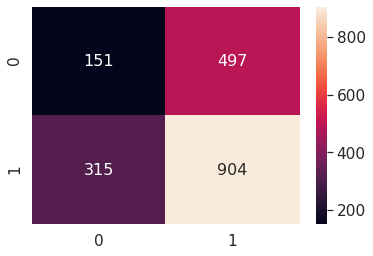

In [ ]:
# plot the confusion matrix

df_cm_incepV3 = pd.DataFrame(confusion_mat_incepV3.numpy())

# for label size
sn.set(font_scale=1.4)
sn.heatmap(df_cm_incepV3, annot=True, fmt='g', annot_kws={'size': 16}) # font size
plt.show()

## ResNet Data

In [ ]:
from tensorflow.keras.applications import ResNet50V2

model_resnet = ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(128,128, 3),
    pooling=None,
    classes=1,
    classifier_activation="softmax",
)

In [ ]:
for layers in model_resnet.layers:
  layers.trainable = False

x = Flatten()(model_resnet.output)

fcc_layer_1 = Dense(units = 1024, activation = 'relu')(x)
dropout_1   = Dropout(0.3)(fcc_layer_1)

fcc_layer_2 = Dense(units = 512, activation = 'relu')(dropout_1)
dropout_2   = Dropout(0.3)(fcc_layer_2)

final_layer = Dense(units = 1, activation = 'sigmoid')(dropout_2)

model_resnet = Model(inputs = model_resnet.input, outputs = final_layer)

model_resnet.compile(optimizer = 'adam', 
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [ ]:
model_resnet = tf.keras.models.load_model('best_weights_resnet.hdf5')

In [ ]:
model_resnet_eval = model_resnet.evaluate(test_data_128, batch_size=128)

117/117 [==============================] - 9s 74ms/step - loss: 2.9765 - accuracy: 0.6535


In [ ]:
# obtain the model loss and accuracy
loss_resnet = model_resnet_eval[0]
accuracy_resnet = model_resnet_eval[1]

In [ ]:
predict_resnet = model_resnet.predict(test_data_128, batch_size=128)

In [ ]:
# Computes confidence interval without changing the network architecture
# assuming Gaussian distribution of prediction accuracy

# size of our test dataset
n = predict_resnet.shape[0]

# assuming 95% confidence interval
Z = 1.96

conf_radius_resnet = Z * np.sqrt((accuracy_resnet * (1 - accuracy_resnet)) / n)

conf_resnet_lower = accuracy_resnet - conf_radius_resnet
conf_resnet_upper = accuracy_resnet + conf_radius_resnet

In [ ]:
print('radius: ', conf_radius_resnet)
print('lower bound: ', conf_resnet_lower)
print('upper bound: ', conf_resnet_upper)

radius:  0.021585974305516096
lower bound:  0.6318687466684524
upper bound:  0.6750406952794846


In [ ]:
# reshaping test_labels so it's same shape as predictions

test_labels_reshape = test_labels.reshape((test_labels.shape[0], 1))

# convert numpy arrays to tensors before calling tf confusion matrix function

test_labels_reshape_tensor = tf.constant(test_labels)
predict_resnet_tensor = tf.constant(predict_resnet)

In [ ]:
# use the tensorflow confusion matrix function

confusion_mat_resnet = tf.math.confusion_matrix(labels=test_labels_reshape_tensor,
                         predictions=predict_resnet_tensor,
                         num_classes=2)

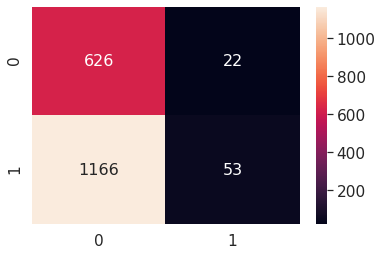

In [ ]:
# for plotting the matrix 
import seaborn as sn

# plot the confusion matrix

df_cm_resnet = pd.DataFrame(confusion_mat_resnet.numpy())

# for label size
sn.set(font_scale=1.4)
sn.heatmap(df_cm_resnet, annot=True, fmt='g', annot_kws={'size': 16}) # font size
plt.show()

## Flipped Data Augmentation Data

In [ ]:
model_train_flipped_data = model_default

model_train_flipped_data.load_weights('w_flipped.hdf5')

In [ ]:
model_train_flipped_eval = model_train_flipped_data.evaluate(test_data, batch_size=128)

117/117 [==============================] - 9s 73ms/step - loss: 8.6205 - accuracy: 0.6031 - precision: 0.6511


In [ ]:
# obtain the model loss and accuracy
loss_flipped = model_train_flipped_eval[0]
accuracy_flipped = model_train_flipped_eval[1]
precision_flipped = model_train_flipped_eval[2]

In [ ]:
predict_train_flipped = model_train_flipped_data.predict(test_data, batch_size=128)

In [ ]:
# Computes confidence interval without changing the network architecture
# assuming Gaussian distribution of prediction accuracy

# size of our test dataset
n = predict_train_flipped.shape[0]

# assuming 95% confidence interval
Z = 1.96

conf_radius_flipped = Z * np.sqrt((accuracy_flipped * (1 - accuracy_flipped)) / n)

conf_flipped_lower = accuracy_flipped - conf_radius_flipped
conf_flipped_upper = accuracy_flipped + conf_radius_flipped

In [ ]:
print('radius: ', conf_radius_flipped)
print('lower bound: ', conf_flipped_lower)
print('upper bound: ', conf_flipped_upper)

radius:  0.022193096382178312
lower bound:  0.5809134619407281
upper bound:  0.6252996547050849


In [ ]:
# reshaping test_labels so it's same shape as predictions

test_labels_reshape = test_labels.reshape((test_labels.shape[0], 1))

# convert numpy arrays to tensors before calling tf confusion matrix function

test_labels_reshape_tensor = tf.constant(test_labels)
predict_flipped_tensor = tf.constant(predict_train_flipped)

In [ ]:
# use the tensorflow confusion matrix function

confusion_mat_flipped = tf.math.confusion_matrix(labels=test_labels_reshape_tensor,
                         predictions=predict_flipped_tensor,
                         num_classes=2)

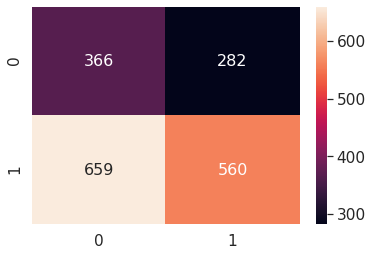

In [ ]:
# for plotting the matrix 
import seaborn as sn

# plot the confusion matrix

df_cm_flipped = pd.DataFrame(confusion_mat_flipped.numpy())

# for label size
sn.set(font_scale=1.4)
sn.heatmap(df_cm_flipped, annot=True, fmt='g', annot_kws={'size': 16}) # font size
plt.show()

## Noise Data Augmentation Data


In [ ]:
model_train_noise_data = model_default

model_train_noise_data.load_weights('retrain_noise.hdf5')

In [ ]:
model_train_noise_eval = model_train_noise_data.evaluate(test_data, batch_size=128)

117/117 [==============================] - 8s 71ms/step - loss: 1.9245 - accuracy: 0.3594 - precision: 0.6949


In [ ]:
# obtain the model loss and accuracy
loss_noise = model_train_noise_eval[0]
accuracy_noise = model_train_noise_eval[1]
precision_noise = model_train_noise_eval[2]

In [ ]:
predict_train_noise = model_train_noise_data.predict(test_data, batch_size=128)

In [ ]:
# Computes confidence interval without changing the network architecture
# assuming Gaussian distribution of prediction accuracy

# size of our test dataset
n = predict_train_noise.shape[0]

# assuming 95% confidence interval
Z = 1.96

conf_radius_noise = Z * np.sqrt((accuracy_noise * (1 - accuracy_noise)) / n)

conf_noise_lower = accuracy_noise - conf_radius_noise
conf_noise_upper = accuracy_noise + conf_radius_noise

In [ ]:
print('radius: ', conf_radius_noise)
print('lower bound: ', conf_noise_lower)
print('upper bound: ', conf_noise_upper)

radius:  0.021765389365465224
lower bound:  0.3376347041899852
upper bound:  0.3811654829209157


In [ ]:
# reshaping test_labels so it's same shape as predictions

test_labels_reshape = test_labels.reshape((test_labels.shape[0], 1))

# convert numpy arrays to tensors before calling tf confusion matrix function

test_labels_reshape_tensor = tf.constant(test_labels)
predict_noise_tensor = tf.constant(predict_train_noise)

In [ ]:
# use the tensorflow confusion matrix function

confusion_mat_noise = tf.math.confusion_matrix(labels=test_labels_reshape_tensor,
                         predictions=predict_noise_tensor,
                         num_classes=2)

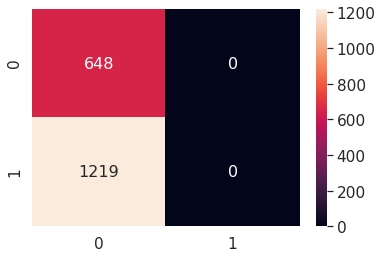

In [ ]:
# for plotting the matrix 
import seaborn as sn

# plot the confusion matrix

df_cm_noise = pd.DataFrame(confusion_mat_noise.numpy())

# for label size
sn.set(font_scale=1.4)
sn.heatmap(df_cm_noise, annot=True, fmt='g', annot_kws={'size': 16}) # font size
plt.show()

## Blur Data Augmentation Data

In [ ]:
model_train_blur_data = model_default

In [ ]:
# save the model weights
model_train_blur_data.load_weights('retrain_blur.hdf5')

In [ ]:
# evaluate the retrained model
model_train_blur_data_eval = model_train_blur_data.evaluate(test_data, batch_size=128)

117/117 [==============================] - 9s 74ms/step - loss: 1.5392 - accuracy: 0.3498 - precision: 0.6923


In [ ]:
# obtain the model loss and accuracy
loss_blur = model_train_blur_data_eval[0]
accuracy_blur = model_train_blur_data_eval[1]
precision_blur = model_train_blur_data_eval[2]

In [ ]:
predict_train_blur = model_train_blur_data.predict(test_data, batch_size=128)

In [ ]:
# Computes confidence interval without changing the network architecture
# assuming Gaussian distribution of prediction accuracy

# size of our test dataset
n = predict_train_blur.shape[0]

# assuming 95% confidence interval
Z = 1.96

conf_radius_blur = Z * np.sqrt((accuracy_blur * (1 - accuracy_blur)) / n)

conf_blur_lower = accuracy_blur - conf_radius_blur
conf_blur_upper = accuracy_blur + conf_radius_blur

In [ ]:
print('radius: ', conf_radius_blur)
print('lower bound: ', conf_blur_lower)
print('upper bound: ', conf_blur_upper)

radius:  0.021632441184738505
lower bound:  0.3281265414736477
upper bound:  0.37139142384312473


In [ ]:
# reshaping test_labels so it's same shape as predictions

test_labels_reshape = test_labels.reshape((test_labels.shape[0], 1))

# convert numpy arrays to tensors before calling tf confusion matrix function

test_labels_reshape_tensor = tf.constant(test_labels)
predict_blur_tensor = tf.constant(predict_train_blur)

In [ ]:
# use the tensorflow confusion matrix function

confusion_mat_blur = tf.math.confusion_matrix(labels=test_labels_reshape_tensor,
                         predictions=predict_blur_tensor,
                         num_classes=2)

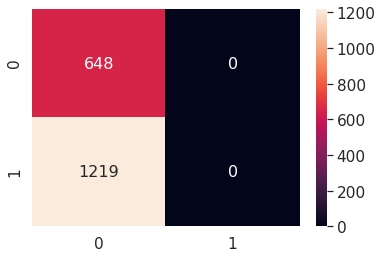

In [ ]:
# for plotting the matrix 
import seaborn as sn

# plot the confusion matrix

df_cm_blur = pd.DataFrame(confusion_mat_blur.numpy())

# for label size
sn.set(font_scale=1.4)
sn.heatmap(df_cm_blur, annot=True, fmt='g', annot_kws={'size': 16}) # font size
plt.show()

Function to implement Confusion Matrix

In [ ]:
import seaborn as sn

# create a function that generates and plots confusion matrices (for convenience)
def createPlotConfusionMatrix(real_labels, predict_labels):
  # try converting to classification prediction instead of using full prediction
  pred = []
  count = 0
  for g in predict_labels.ravel():
   if g < 0.5:
     pred.append(0)
   else:
     pred.append(1)
  
  # reshaping test_labels so it's same shape as predictions
  real_labels_reshape = real_labels.reshape((real_labels.shape[0], 1))

  # convert numpy arrays to tensors before calling tf confusion matrix function
  real_labels_reshape_tensor = tf.constant(real_labels)

  # predict_blur_tensor = tf.constant(predict_train_blur)
  predict_tensor = tf.constant(pred)

  # use the tensorflow confusion matrix function
  confusion_mat = tf.math.confusion_matrix(labels=real_labels_reshape_tensor,
                         predictions=predict_tensor,
                         num_classes=2)

  # plot the confusion matrix
  df_cm = pd.DataFrame(confusion_mat.numpy())

  # for label size
  sn.set(font_scale=1.4)
  sn.heatmap(df_cm, annot=True, fmt='g', annot_kws={'size': 16}) # font size
  plt.show()

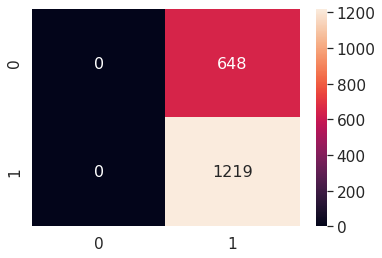

In [ ]:
# plot for InceptionV3
createPlotConfusionMatrix(test_labels, predict_incepV3)

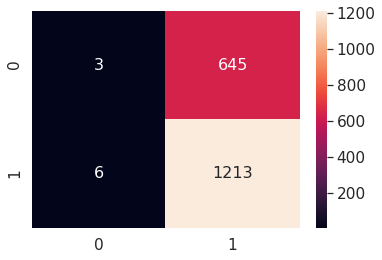

In [ ]:
# plot for ResNet
createPlotConfusionMatrix(test_labels, predict_resnet)

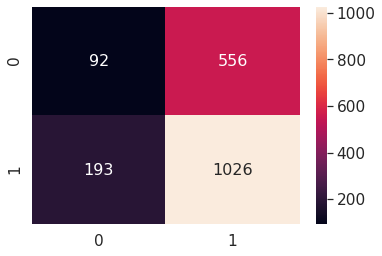

In [ ]:
# plot for Flipped Transfer
createPlotConfusionMatrix(test_labels, predict_train_flipped)

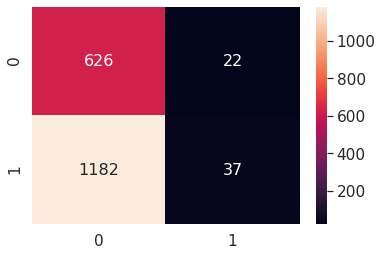

In [ ]:
# plot for Noise Transfer
createPlotConfusionMatrix(test_labels, predict_train_noise)

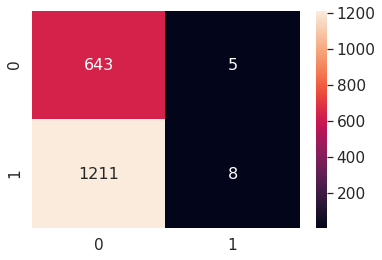

In [ ]:
# plot for Blur Transfer
createPlotConfusionMatrix(test_labels, predict_train_blur)

# Re-training Models for ROC plots

In [ ]:
train_data_128 = tf.keras.preprocessing.image_dataset_from_directory(
    './C-NMC_Leukemia/training_data/fold_0',
    labels="inferred",
    class_names=["all", "hem"],
    label_mode="int",
    image_size=(128, 128),
    batch_size=BATCH_SIZE, 
)

Found 8531 files belonging to 2 classes.


In [ ]:
# define (128, 128) image data for the training

test_data_128 = tf.keras.preprocessing.image_dataset_from_directory(
    './C-NMC_Leukemia/validation_data/',
    labels=test_labels.tolist(),
    label_mode="int",
    image_size=(128, 128),
    batch_size=BATCH_SIZE, 
)

Found 1867 files belonging to 1 classes.


In [ ]:
val_data_128 = tf.keras.preprocessing.image_dataset_from_directory(
    './C-NMC_Leukemia/training_data/val',
    labels="inferred",
    class_names=["all", "hem"],
    label_mode="int",
    image_size=(128, 128),
    batch_size=BATCH_SIZE,
)

Found 2130 files belonging to 2 classes.


## Retrain InceptionV3 Model

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.layers import InputLayer, Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [ ]:
# Creating model with pre trained imagenet weights

incep_v3 = InceptionV3(include_top=False, weights='imagenet', input_shape=(128,128,3))

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
# We dont want to train all layers so, we do following step because we are using same weights given in VGG16

for layers in incep_v3.layers:
    layers.trainable = False

In [ ]:
# Introducing Flatten Layer

x = Flatten()(incep_v3.output)

# Introducing FCC & Output Layer

fcc_layer_1 = Dense(units = 1024, activation = 'relu')(x)
dropout_1   = Dropout(0.3)(fcc_layer_1)

fcc_layer_2 = Dense(units = 512, activation = 'relu')(dropout_1)
dropout_2   = Dropout(0.3)(fcc_layer_2)

final_layer = Dense(units = 1, activation = 'sigmoid')(dropout_2)

In [ ]:
# Creating Final Model

model = Model(inputs = incep_v3.input, outputs = final_layer)

In [ ]:
# Model Compile 

model.compile(optimizer = 'adam', 
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [ ]:
# Defining Callbacks

filepath = './retrain_best_weights_inception.hdf5'

earlystopping = EarlyStopping(monitor = 'val_accuracy', 
                              mode = 'max' , 
                              patience = 15,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_accuracy', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)

learning_rate = ReduceLROnPlateau(monitor = 'val_accuracy',
                                  mode = 'max',
                                  patience = 5,
                                  factor = 0.3,
                                  min_delta = 0.00001)


callback_list = [earlystopping, checkpoint, learning_rate]

In [ ]:
# Fitting Model

model_inception_history = model.fit(train_data_128, 
                          validation_data=val_data_128,
                          epochs=500,
                          verbose=1,
                          callbacks=callback_list)

Epoch 1/500
534/534 [==============================] - ETA: 0s - loss: 3.3350 - accuracy: 0.7298
Epoch 00001: val_accuracy improved from -inf to 0.78967, saving model to ./retrain_best_weights_inception.hdf5
534/534 [==============================] - 1236s 2s/step - loss: 3.3350 - accuracy: 0.7298 - val_loss: 0.5185 - val_accuracy: 0.7897
Epoch 2/500
532/534 [============================>.] - ETA: 0s - loss: 0.5910 - accuracy: 0.7361
Epoch 00002: val_accuracy did not improve from 0.78967
534/534 [==============================] - 178s 333ms/step - loss: 0.5908 - accuracy: 0.7363 - val_loss: 0.5203 - val_accuracy: 0.7765
Epoch 3/500
532/534 [============================>.] - ETA: 0s - loss: 0.5859 - accuracy: 0.7418
Epoch 00003: val_accuracy did not improve from 0.78967
534/534 [==============================] - 178s 333ms/step - loss: 0.5859 - accuracy: 0.7421 - val_loss: 0.5650 - val_accuracy: 0.7887
Epoch 4/500
532/534 [============================>.] - ETA: 0s - loss: 0.5943 - accur

In [ ]:
# model_retrain_noise.model.save_weights('./retrain_imbalance/noise')
model_inception_history.model.save('./retrain_inception_resnet/inception')

model_inception_history.model.evaluate(test_data_128, batch_size=128)

INFO:tensorflow:Assets written to: ./retrain_inception_resnet/inception/assets
117/117 [==============================] - 282s 2s/step - loss: 0.8816 - accuracy: 0.3471


[0.8815616965293884, 0.34708088636398315]

In [ ]:
# Save history
with open('./retrain_inception_resnet/inception_history', 'wb') as file_pi:
  pickle.dump(model_inception_history.history, file_pi)

## Retrain ResNet Model

In [ ]:
from tensorflow.keras.applications import ResNet50V2

In [ ]:
model_resnet = ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(128,128, 3),
    pooling=None,
    classes=1,
    classifier_activation="softmax",
)

In [ ]:
for layers in model_resnet.layers:
  layers.trainable = False

x = Flatten()(model_resnet.output)

fcc_layer_1 = Dense(units = 1024, activation = 'relu')(x)
dropout_1   = Dropout(0.3)(fcc_layer_1)

fcc_layer_2 = Dense(units = 512, activation = 'relu')(dropout_1)
dropout_2   = Dropout(0.3)(fcc_layer_2)

final_layer = Dense(units = 1, activation = 'sigmoid')(dropout_2)

model_resnet = Model(inputs = model_resnet.input, outputs = final_layer)

model_resnet.compile(optimizer = 'adam', 
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [ ]:
filepath = './retrain_best_weights_resnet.hdf5'

earlystopping = EarlyStopping(monitor = 'val_accuracy', 
                              mode = 'max' , 
                              patience = 15,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_accuracy', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)

learning_rate = ReduceLROnPlateau(monitor = 'val_accuracy',
                                  mode = 'max',
                                  patience = 5,
                                  factor = 0.3,
                                  min_delta = 0.00001)


callback_list = [earlystopping, checkpoint, learning_rate]

In [ ]:
model_resnet_history = model_resnet.fit(train_data_128, 
                          validation_data=val_data_128,
                          epochs=500,
                          verbose=1,
                          callbacks=callback_list)

Epoch 1/500
534/534 [==============================] - ETA: 0s - loss: 10.6378 - accuracy: 0.7202
Epoch 00001: val_accuracy improved from -inf to 0.78404, saving model to ./retrain_best_weights_resnet.hdf5
534/534 [==============================] - 3306s 6s/step - loss: 10.6378 - accuracy: 0.7202 - val_loss: 0.5602 - val_accuracy: 0.7840
Epoch 2/500
532/534 [============================>.] - ETA: 0s - loss: 0.6140 - accuracy: 0.7355
Epoch 00002: val_accuracy did not improve from 0.78404
534/534 [==============================] - 178s 333ms/step - loss: 0.6137 - accuracy: 0.7358 - val_loss: 0.6268 - val_accuracy: 0.6812
Epoch 3/500
532/534 [============================>.] - ETA: 0s - loss: 0.6526 - accuracy: 0.6816
Epoch 00003: val_accuracy did not improve from 0.78404
534/534 [==============================] - 178s 333ms/step - loss: 0.6524 - accuracy: 0.6817 - val_loss: 0.6263 - val_accuracy: 0.6808
Epoch 4/500
532/534 [============================>.] - ETA: 0s - loss: 0.6333 - accura

In [ ]:
# model_retrain_noise.model.save_weights('./retrain_imbalance/noise')
model_resnet_history.model.save('./retrain_inception_resnet/resnet')

model_resnet_history.model.evaluate(test_data_128, batch_size=128)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./retrain_inception_resnet/resnet/assets
117/117 [==============================] - 495s 4s/step - loss: 0.8766 - accuracy: 0.3465


[0.8766463994979858, 0.3465452492237091]

In [ ]:
# Save history
with open('./retrain_inception_resnet/resnet_history', 'wb') as file_pi:
  pickle.dump(model_resnet_history.history, file_pi)

# Confidence Interval Bar Plots

In [ ]:
# width of the bars
barWidth = 0.3

In [ ]:
# choose the weight of the bars (for Inception, Resnet, and 3 transfer learning)

acc_incepV3 = accuracy_incepv3
acc_resnet = accuracy_resnet
acc_flip = accuracy_flipped
acc_noise = accuracy_noise
acc_blur = accuracy_blur

conf_int_incepV3 = conf_radius_incepV3
conf_int_resnet = conf_radius_resnet
conf_int_flip = conf_radius_flipped
conf_int_noise = conf_radius_noise
conf_int_blur = conf_radius_blur

## Confidence Interval for InceptionV3, ResNet and 3 Transfer Learnings (combined)

In [ ]:
def confIntervalBarChart(bars, yer, labels):
  # x position of the bars
  r1 = np.arange(len(bars))
  r2 = [x + barWidth for x in r1]

  # create blur bars
  plt.bar(r1, bars, width=barWidth, color='cyan', edgecolor='black', yerr=yer, capsize=7)

  # general layout
  plt.xticks([r + barWidth for r in range(len(bars))], labels)
  plt.ylabel('accuracy')

  # Show graphic
  plt.show()

Displaying confidence intervals for all 5 at once. If I want to create charts for only a single model, we can run the function on smaller lists.

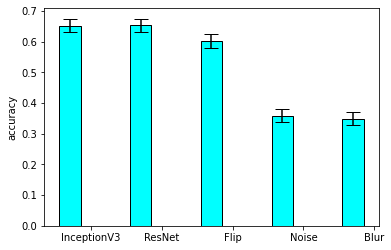

In [ ]:
allBars = [acc_incepV3, acc_resnet, acc_flip, acc_noise, acc_blur]
allYers = [conf_int_incepV3, conf_int_resnet, conf_int_flip, conf_int_noise, conf_int_blur]
allLabels = ['InceptionV3', 'ResNet', 'Flip', 'Noise', 'Blur']

# display confidence intervals for all 5 models at once
confIntervalBarChart(allBars, allYers, allLabels)

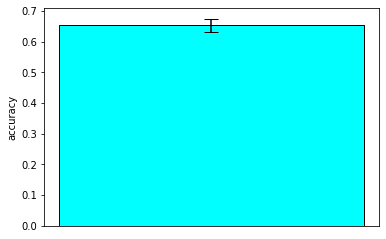

In [ ]:
# confidence interval for only InceptionV3
incepV3Bars = [acc_incepV3]
incepV3Yers = [conf_int_incepV3]
incepV3Labels = ['InceptionV3']

confIntervalBarChart(incepV3Bars, incepV3Yers, incepV3Labels)

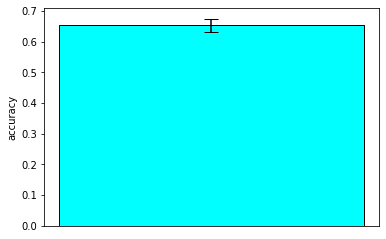

In [ ]:
# confidence interval for only ResNet
resnetBars = [acc_resnet]
resnetYers = [conf_int_resnet]
resnetLabels = ['ResNet']

confIntervalBarChart(resnetBars, resnetYers, resnetLabels)

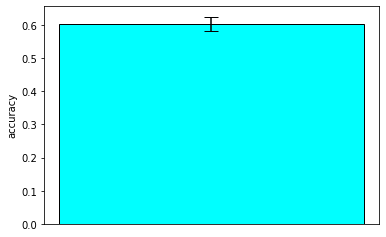

In [ ]:
# confidence interval for only Flipped Transfer Learn
flipBars = [acc_flip]
flipYers = [conf_int_flip]
flipLabels = ['Flip']

confIntervalBarChart(flipBars, flipYers, flipLabels)

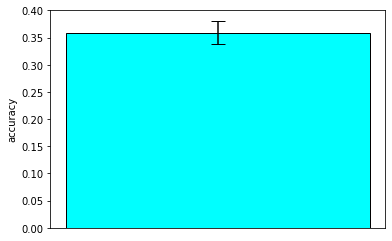

In [ ]:
# confidence interval for only Noise Transfer Learn
noiseBars = [acc_noise]
noiseYers = [conf_int_noise]
noiseLabels = ['Noise']

confIntervalBarChart(noiseBars, noiseYers, noiseLabels)

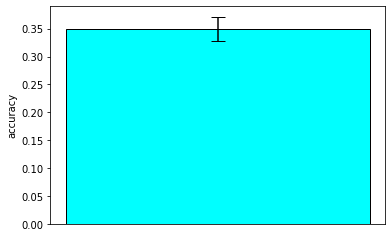

In [ ]:
# confidence interval for only Blur Transfer Learn
blurBars = [acc_blur]
blurYers = [conf_int_blur]
blurLabels = ['Blur']

confIntervalBarChart(blurBars, blurYers, blurLabels)

Commenting below (implemented as function)

In [ ]:
# x position of the bars
# r1 = np.arange(len(bars))
# r2 = [x + barWidth for x in r1]

# create blur bars
# plt.bar(r1, bars, width=barWidth, color='blue', edgecolor='black', yerr=yer, capsize=7)

# general layout
# plt.xticks([r + barWidth for r in range(len(bars))], ['InceptionV3', 'ResNet', 'Flip', 'Noise', 'Blur'])
# plt.ylabel('accuracy')

# Show graphic
# plt.show()

# ROC Curves (TODO plot for all of them)

In [ ]:
import pickle

## Load Files

In [ ]:
# model_retrain_5     = tf.keras.models.load_model('./retrain_inception_resnet/5.hdf5')
model_retrain_flipped  = tf.keras.models.load_model('./retrain_inception_resnet/flipped')
model_retrain_noise = tf.keras.models.load_model('./retrain_inception_resnet/noise')
model_retrain_blur  = tf.keras.models.load_model('./retrain_inception_resnet/blur')
model_retrain_inception = tf.keras.models.load_model('./retrain_inception_resnet/inception')
model_retrain_resnet = tf.keras.models.load_model('./retrain_inception_resnet/resnet')

## Load Histories

In [ ]:
# history_5 = pickle.load(open('./retrain_imbalance/5_history', "rb"))
history_flipped = pickle.load(open('./retrain_inception_resnet/flipped_history', "rb"))
history_noise = pickle.load(open('./retrain_inception_resnet/noise_history', "rb"))
history_blur = pickle.load(open('./retrain_inception_resnet/blur_history', "rb"))
history_inception = pickle.load(open('./retrain_inception_resnet/inception_history', "rb"))
history_resnet = pickle.load(open('./retrain_inception_resnet/resnet_history', "rb"))

In [ ]:
# print(history_5.keys())

## ROC

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [ ]:
# predict the model
# TODO do we make batch size 128?
hi = model_retrain_flipped.predict(test_data, batch_size=128)

In [ ]:
print(len(hi))

1867


In [ ]:
# uses our default comparison (model flipped) as our comparison
pred = []
count = 0
for g in hi.ravel():
  if g < 0.5:
    count +=1
    pred.append(0)
  else:
    pred.append(1)
print(count)

1685


In [ ]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_labels, pred)

In [ ]:
auc_keras = auc(fpr_keras, tpr_keras)

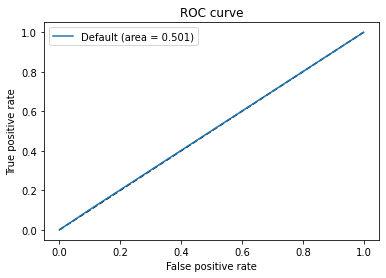

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Default (area = {:.3f})'.format(auc_keras))
# plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [ ]:
# TODO is something wrong with displaying the information???
# implement ROC as a function
def createROCPlot(model, test_data):
  # predict the model
  hi = model.predict(test_data, batch_size=128)

  pred = hi.ravel()
  # TODO implement this
  #pred = []
  #count = 0
  #for g in hi.ravel():
  #  if g < 0.5:
  #    count +=1
  #    pred.append(0)
  #  else:
  #    pred.append(1)


  # y_true: true binary labels
  # y_score: target scores, can be probability estimates of a positive class
  #   or non-threshold measure of decisions
  fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_true=test_labels,
                                                     y_score=pred,
                                                     pos_label=1)

  # compute the area under the curve
  auc_keras = auc(fpr_keras, tpr_keras)

  plt.figure(1)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr_keras, tpr_keras, label='Default (area = {:.3f})'.format(auc_keras))
  # plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve')
  plt.legend(loc='best')
  plt.show()

Plot the ROC plots for InceptionV3, ResNet, and 3 Transfer Learning Models

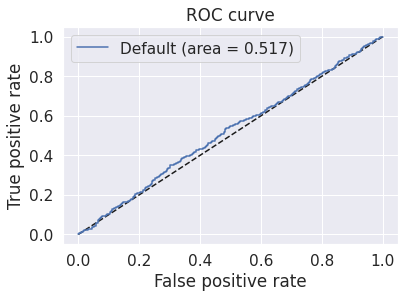

In [ ]:
# flipped
createROCPlot(model_retrain_flipped, test_data)

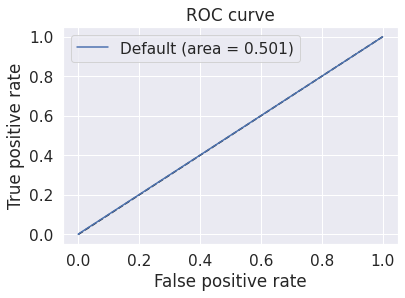

In [ ]:
# InceptionV3
createROCPlot(model_retrain_inception, test_data_128)

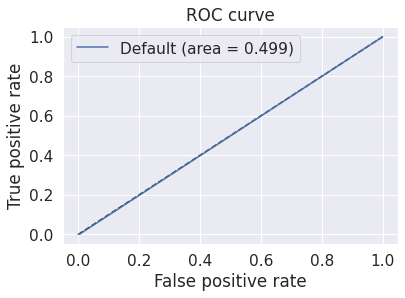

In [ ]:
# ResNet
createROCPlot(model_retrain_resnet, test_data_128)

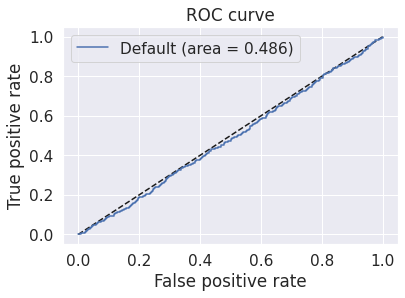

In [ ]:
# noise
createROCPlot(model_retrain_noise, test_data)

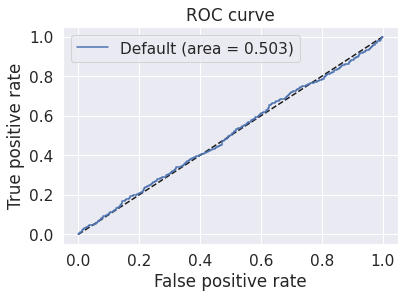

In [ ]:
# blur
createROCPlot(model_retrain_blur, test_data)

# Plot of Model Training Data

In [ ]:
# function that plots the val loss and val accuracy
def summarizeLossAccuracy(history):
  # list the names of the keys
  print(history.keys())

  # plot the accuracy and val accuracy
  plt.plot(history['accuracy'])
  plt.plot(history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  # summarize history for loss
  plt.plot(history['loss'])
  plt.plot(history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


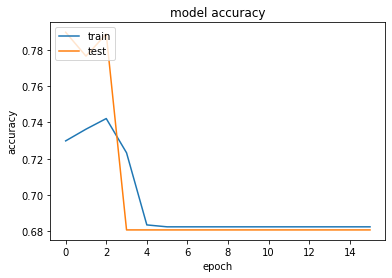

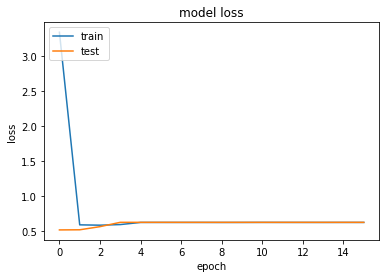

In [ ]:
# summarize val loss and accuracy for InceptionV3
summarizeLossAccuracy(history_inception)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


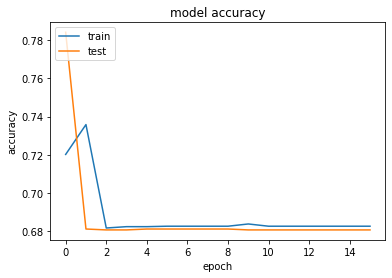

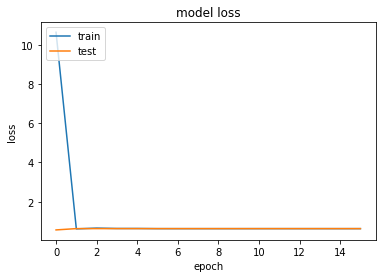

In [ ]:
# summarize val loss and accuracy for ResNet
summarizeLossAccuracy(history_resnet)

dict_keys(['loss', 'accuracy', 'precision', 'val_loss', 'val_accuracy', 'val_precision'])


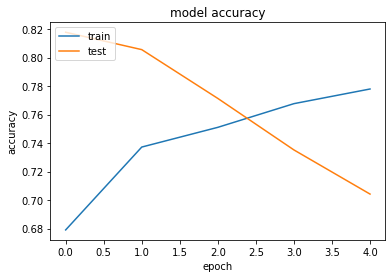

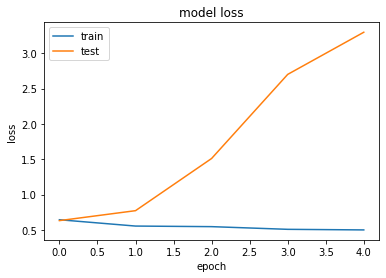

In [ ]:
# summarize val loss and accuracy for flipped
summarizeLossAccuracy(history_flipped)

dict_keys(['loss', 'accuracy', 'precision', 'val_loss', 'val_accuracy', 'val_precision'])


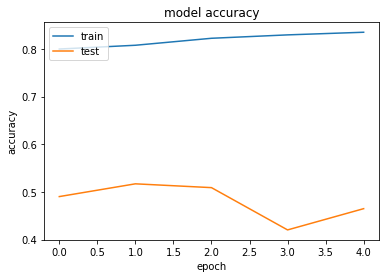

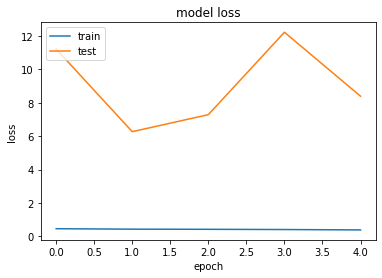

In [ ]:
# summarize val loss and accuracy for noise
summarizeLossAccuracy(history_noise)

dict_keys(['loss', 'accuracy', 'precision', 'val_loss', 'val_accuracy', 'val_precision'])


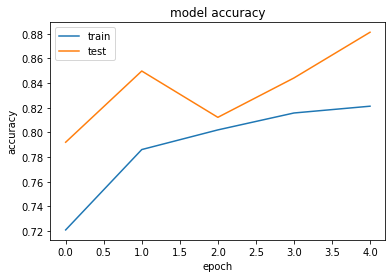

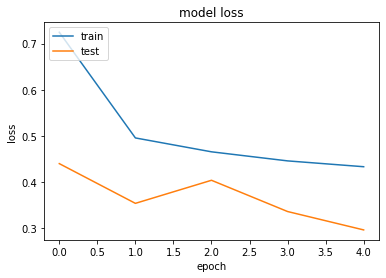

In [ ]:
# summarize val loss and accuracy for blur
summarizeLossAccuracy(history_blur)

# Error Bars for Retrain Data

## Load Models


In [ ]:
model_inception = tf.keras.models.load_model('./retrain_inception_resnet/inception')
model_resnet    = tf.keras.models.load_model('./retrain_inception_resnet/resnet')

model_retrain_5     = tf.keras.models.load_model('./retrain_imbalance/5.hdf5')
model_retrain_flip  = tf.keras.models.load_model('./retrain_imbalance/flip')
model_retrain_noise = tf.keras.models.load_model('./retrain_imbalance/noise')
model_retrain_blur  = tf.keras.models.load_model('./retrain_imbalance/blur')

## Load Histories

In [ ]:
import pickle

history_inception = pickle.load(open('./retrain_inception_resnet/inception_history', "rb"))
resnet_inception  = pickle.load(open('./retrain_inception_resnet/resnet_history', "rb"))

history_5 = pickle.load(open('./retrain_imbalance/5_history', "rb"))
history_flip = pickle.load(open('./retrain_imbalance/flip_history', "rb"))
history_noise = pickle.load(open('./retrain_imbalance/noise_history', "rb"))
history_blur = pickle.load(open('./retrain_imbalance/blur_history', "rb"))

## Predict and Evaluate from Models

In [ ]:
def getAccuracyErrors(predict, acc):
  # number of samples
  n = predict.shape[0]

  # assuming 95% confidence interval
  Z = 1.96

  radius = Z * np.sqrt((acc * (1 - acc)) / n)
  lower = acc - radius
  upper = acc + radius

  return radius, lower, upper

In [ ]:
# predict from the default model
pred_5 = model_retrain_5.predict(test_data)

eval_5 = model_retrain_5.evaluate(test_data)

117/117 [==============================] - 8s 66ms/step - loss: 2.8559 - accuracy: 0.3605 - precision: 0.7358


In [ ]:
# obtain the model loss, accuracy, and precision
print(eval_5)

loss_5 = eval_5[0]
accuracy_5 = eval_5[1]
precision_5 = eval_5[2]

[2.855910062789917, 0.36047133803367615, 0.7358490824699402]


In [ ]:
radius_5, lower_5, upper_5 = getAccuracyErrors(pred_5, accuracy_5)

print('radius: ', radius_5)
print('lower bound: ', lower_5)
print('upper bounds: ', upper_5)

radius:  0.02177956935596049
lower bound:  0.33869176867771567
upper bounds:  0.38225090738963663


In [ ]:
pred_retrain_flip = model_retrain_flip.predict(test_data)

eval_retrain_flip = model_retrain_flip.evaluate(test_data)

117/117 [==============================] - 8s 65ms/step - loss: 4.0951 - accuracy: 0.3771 - precision: 0.6333


In [ ]:
# obtain the model loss, accuracy, and precision
print(eval_retrain_flip)

loss_retrain_flip = eval_retrain_flip[0]
accuracy_retrain_flip = eval_retrain_flip[1]
precision_retrain_flip = eval_retrain_flip[2]

[4.095114231109619, 0.37707552313804626, 0.6333333253860474]


In [ ]:
radius_retrain_flip, lower_retrain_flip, upper_retrain_flip = getAccuracyErrors(pred_retrain_flip, accuracy_retrain_flip)

print('radius: ', radius_retrain_flip)
print('lower bound: ', lower_retrain_flip)
print('upper bounds: ', upper_retrain_flip)

radius:  0.021984458935883536
lower bound:  0.35509106420216274
upper bounds:  0.3990599820739298


In [ ]:
pred_retrain_noise = model_retrain_noise.predict(test_data)

eval_retrain_noise = model_retrain_noise.evaluate(test_data)

117/117 [==============================] - 8s 65ms/step - loss: 4.7992 - accuracy: 0.3931 - precision: 0.6483


In [ ]:
# obtain the model loss, accuracy, and precision
print(eval_retrain_noise)

loss_retrain_noise = eval_retrain_noise[0]
accuracy_retrain_noise = eval_retrain_noise[1]
precision_retrain_noise = eval_retrain_noise[2]

[4.799220085144043, 0.39314407110214233, 0.6482758522033691]


In [ ]:
radius_retrain_noise, lower_retrain_noise, upper_retrain_noise = getAccuracyErrors(pred_retrain_noise, accuracy_retrain_noise)

print('radius: ', radius_retrain_noise)
print('lower bound: ', lower_retrain_noise)
print('upper bounds: ', upper_retrain_noise)

radius:  0.022156572450724138
lower bound:  0.3709874986514182
upper bounds:  0.41530064355286644


In [ ]:
pred_retrain_blur = model_retrain_blur.predict(test_data)

eval_retrain_blur = model_retrain_blur.evaluate(test_data)

117/117 [==============================] - 8s 64ms/step - loss: 7.6598 - accuracy: 0.3878 - precision: 0.6319


In [ ]:
# obtain the model loss, accuracy, and precision
print(eval_retrain_blur)

loss_retrain_blur = eval_retrain_blur[0]
accuracy_retrain_blur = eval_retrain_blur[1]
precision_retrain_blur = eval_retrain_blur[2]

[7.659763813018799, 0.38778790831565857, 0.6319444179534912]


In [ ]:
radius_retrain_blur, lower_retrain_blur, upper_retrain_blur = getAccuracyErrors(pred_retrain_blur, accuracy_retrain_blur)

print('radius: ', radius_retrain_blur)
print('lower bound: ', lower_retrain_blur)
print('upper bounds: ', upper_retrain_blur)

radius:  0.022102021419511522
lower bound:  0.36568588689614706
upper bounds:  0.4098899297351701


In [ ]:
def confIntervalBarChart(bars, yer, labels):
  barWidth = 0.3

  # x position of the bars
  r1 = np.arange(len(bars))
  r2 = [x + barWidth for x in r1]

  # create blur bars
  plt.bar(r1, bars, width=barWidth, color='cyan', edgecolor='black', yerr=yer, capsize=7)

  # general layout
  plt.xticks([r + barWidth for r in range(len(bars))], labels)
  plt.ylabel('accuracy')

  # Show graphic
  plt.show()

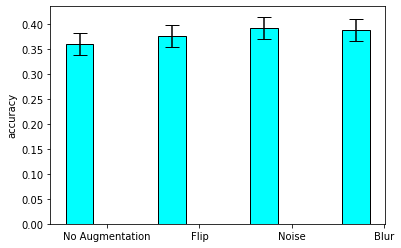

In [ ]:
allBars = [
           accuracy_5,
           accuracy_retrain_flip,
           accuracy_retrain_noise,
           accuracy_retrain_blur
           ]

allYers = [
           radius_5,
           radius_retrain_flip,
           radius_retrain_noise,
           radius_retrain_blur
           ]

allLabels = ['No Augmentation', 'Flip', 'Noise', 'Blur']

# display confidence intervals for all 5 models at once
confIntervalBarChart(allBars, allYers, allLabels)

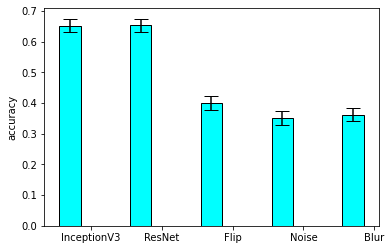

In [ ]:
allBars2 = [
           0.6529,
           0.6535,
           0.3996,
           0.3519,
           0.3621
           ]

allYers2 = [
           0.02159,
           0.02158,
           0.02219,
           0.02176,
           0.02163
           ]

allLabels2 = ['InceptionV3', 'ResNet', 'Flip', 'Noise', 'Blur']

# display confidence intervals for all 5 models at once
confIntervalBarChart(allBars2, allYers2, allLabels2)